Link to Dataset = https://drive.google.com/uc?id=1SjudPhV1QkMqAwVXEWxqNSh7AKxR43bV

# **PART 1**

Install the required libraries

In [39]:
!pip install python_speech_features
import python_speech_features as mfcc
from scipy.io.wavfile import read
import numpy as np
import glob
import pandas as pd
import statistics
import random

**Define the MFCC function.**

In [40]:
def get_MFCC(audio, sr):
    features = mfcc.mfcc(audio, sr, 0.025, 0.01, 13, appendEnergy = True)
    return np.mean(features, axis=0)

Loading Dataset

In [41]:
train_x_files = glob.glob('/content/drive/MyDrive/Dataset/train/**/*.wav', recursive= True)
test_x_files = glob.glob('/content/drive/MyDrive/Dataset/test/**/*.wav', recursive= True)

Separating into train and validation set

In [42]:
## splitting the training data into training and validation data 80:20 ratio
shuffled = random.sample(train_x_files, len(train_x_files))
eighty_percent = round(0.8*len(train_x_files))

train_x_files_val = shuffled[:eighty_percent]
val_files = shuffled[eighty_percent:]

Read and extract MFCC features for WAVE files.

In [43]:
def extraction(audio_files_path_list):
  features_list = []
  labels = []

  for i in range(len(audio_files_path_list)):

    sr, audio = read(audio_files_path_list[i])
    features = get_MFCC(audio, sr)                      ## extracting features 
    features_list.append(features)  
    label = audio_files_path_list[i].split('/')[-1].split('-')[0] ##extracting labels from name
    labels.append(label)

  for i in range(len(features_list)):
    features_list[i] = features_list[i].reshape(1, 13)

  t_X = np.concatenate(features_list)
  ##t_X = np.c_[ np.ones(len(features_list)), t_X ]

  return t_X, labels

In [44]:
## extracting features for each data
train_X , train_Y = extraction(train_x_files)
test_X , test_Y = extraction(test_x_files)
train_X_val, train_Y_val = extraction(train_x_files_val)
val_X, val_Y = extraction(val_files)

making one hot encoded vectors

In [45]:
one_hot_train = pd.get_dummies(train_Y)
one_hot_train = one_hot_train.to_numpy()
train_Y = one_hot_train

one_hot_test = pd.get_dummies(test_Y)
one_hot_test = one_hot_test.to_numpy()
test_Y = one_hot_test

one_hot_train_val = pd.get_dummies(train_Y_val)
one_hot_train_val = one_hot_train_val.to_numpy()
train_Y_val = one_hot_train_val

one_hot_val = pd.get_dummies(val_Y)
one_hot_val = one_hot_val.to_numpy()
val_Y = one_hot_val

Normalising Data

In [46]:
means = train_X.mean(axis=0)
stds = train_X.std(axis=0)

train_X = train_X - means
train_X = train_X/stds
train_X = np.c_[ np.ones(train_X.shape[0]), train_X ]  ## adding bias 

test_X = test_X - means
test_X = test_X/stds
test_X = np.c_[ np.ones(test_X.shape[0]), test_X ]


means = train_X_val.mean(axis=0)
stds = train_X_val.std(axis=0)

train_X_val = train_X_val - means
train_X_val = train_X_val/stds
train_X_val = np.c_[ np.ones(train_X_val.shape[0]), train_X_val ]

val_X = val_X - means
val_X = val_X /stds
val_X = np.c_[ np.ones(val_X.shape[0]), val_X ]

Hypothesis Function

In [47]:
def hypothesis(X, W):
  h = np.matmul(X, W) ## calculates h(x)
  return h

SoftMax Function

In [48]:
def softmax(X):
  X = np.exp(X)
  sums = np.sum(X, axis=1)        #sums of each row 
  sums = sums.reshape(-1,1)       

  X = X / sums
  return X

Cost Function

In [49]:
def crossEntropyLoss(X, Y, W):
  h = hypothesis(X, W)
  h = softmax(h)

  cost = np.log(h)*Y
  cost = (-1/X.shape[0])*np.sum(cost)
  return cost

Gradient Descent

In [50]:
def gradientDes(X, Y, alpha, epochs):

  number_of_classes = Y.shape[1]
  number_of_features = X.shape[1]
  thetas = np.ones( (number_of_features, number_of_classes) )   ## weights vectors
  J = []

  for epoch in range(epochs):
    h = hypothesis(X, thetas)
    h = softmax(h)
    
    difference = h - Y
    difference = difference.T
    temp = np.dot(difference, X)          ## gradient
    temp = (1/X.shape[0])*alpha*temp.T      

    thetas = thetas - temp 
    J.append( crossEntropyLoss(X, Y, thetas) )

  return thetas, J

Predicting Function

In [51]:
def predict(X, W):
  predicted = hypothesis(X, W)
  predicted = softmax(predicted)
  result = np.argmax(predicted, axis=1)   ## predicting labels from probabilities 
  return result

Cross Validation 

In [52]:
## checking 25 combinations of alphas and epochs for best aplha and epoch
alphas = [0.01, 0.005, 0.001, 0.0005, 0.0001 ]
epochs_list = [1000, 5000, 10000, 50000, 100000]

training_loss = []
validation_loss = []

for alpha in alphas:
  my_list_train = []
  my_list_validation = []
  for epoch in epochs_list:
    weights, costs = gradientDes(train_X_val, train_Y_val, alpha, epoch)
    my_list_train.append(costs[-1])                                         ## training loss
    my_list_validation.append(crossEntropyLoss(val_X, val_Y, weights))      ## validation loss
  training_loss.append(my_list_train)
  validation_loss.append(my_list_validation)

Plotting Cross Validation Results

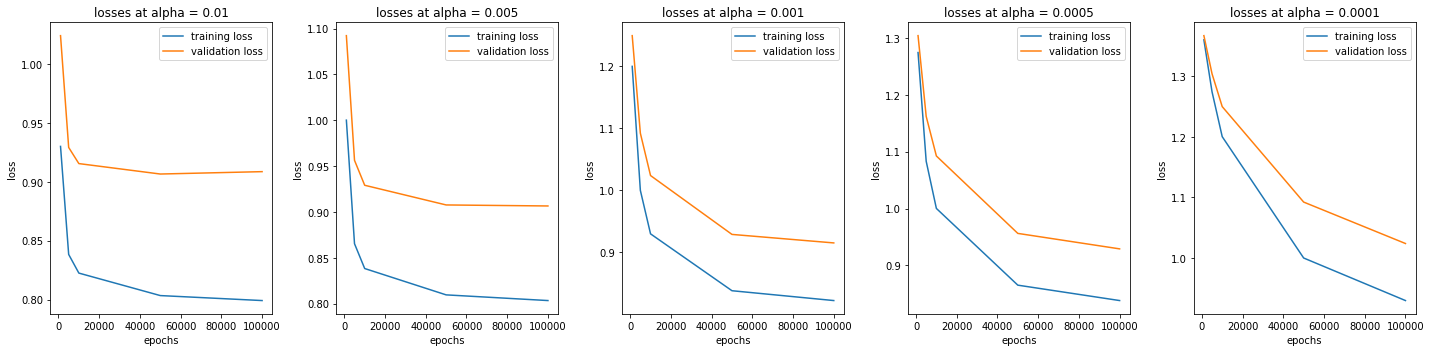

In [53]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
plt.subplot(1,5,1)
plt.plot(epochs_list, training_loss[0])
plt.plot(epochs_list, validation_loss[0])
plt.title('losses at alpha = 0.01')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['training loss', 'validation loss'])

plt.subplot(1,5,2)
plt.plot(epochs_list, training_loss[1])
plt.plot(epochs_list, validation_loss[1])
plt.title('losses at alpha = 0.005')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['training loss', 'validation loss'])

plt.subplot(1,5,3)
plt.plot(epochs_list, training_loss[2])
plt.plot(epochs_list, validation_loss[2])
plt.title('losses at alpha = 0.001')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['training loss', 'validation loss'])

plt.subplot(1,5,4)
plt.plot(epochs_list, training_loss[3])
plt.plot(epochs_list, validation_loss[3])
plt.title('losses at alpha = 0.0005')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['training loss', 'validation loss'])

plt.subplot(1,5,5)
plt.plot(epochs_list, training_loss[4])
plt.plot(epochs_list, validation_loss[4])
plt.title('losses at alpha = 0.0001')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['training loss', 'validation loss'])
plt.tight_layout()
plt.show()


**The lowest error on both training and validation set comes when alpha = 0.005 and epochs = 100000 so using them to train our model and testing it on testing data**

In [54]:
weights, costs = gradientDes(train_X, train_Y, 0.005, 100000)     ## using optimal hyperparameters to train on training data
pred_labels = predict(test_X, weights) ## predicting test data labels

Text(0, 0.5, 'loss')

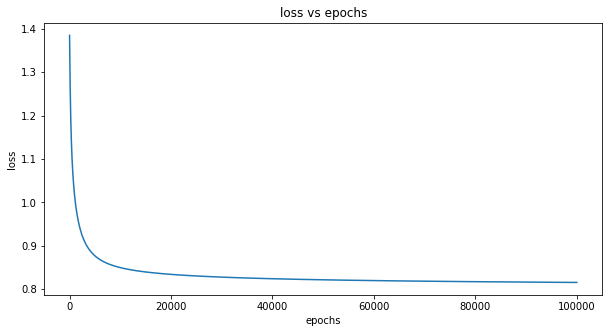

In [55]:
plt.figure(figsize=(10,5))
plt.plot(costs)
plt.title('loss vs epochs')
plt.xlabel('epochs')
plt.ylabel('loss')

In [56]:
def Evaluation(predicted_labels, gold_labels):

  gold_labels = np.argmax(gold_labels, axis=1)

  number_of_class = len(np.unique(gold_labels))
  matrix = np.zeros( (number_of_class, number_of_class) )

  for i in range( len(gold_labels) ):     ## making confusion matrix
    pred_i = predicted_labels[i]
    gold_i = gold_labels[i]
    matrix[pred_i][gold_i] = matrix[pred_i][gold_i] + 1

  precisions = []
  recalls = []
  acc = 0

  for i in range( number_of_class ):      ## calculating precisions and recalls
    precisions.append( matrix[i][i] / matrix[i, :].sum())
    recalls.append( matrix[i][i] / matrix[:, i].sum() )
    acc = acc + matrix[i][i]

  avg_prec = statistics.mean(precisions)      ##avg precision
  avg_recalls = statistics.mean(recalls)    ## avg recall
  f1 = (2*avg_prec*avg_recalls) / (avg_prec + avg_recalls)  ## avg f1 
  acc = acc / matrix.sum()    ## accuracy 
  
  return acc, avg_prec, avg_recalls, f1, matrix

In [57]:
results = Evaluation(pred_labels, test_Y)
print("accuracy =", 100*results[0])
print("Precision =", 100*results[1])
print("Recall =", 100*results[2])
print("F1-Score =", 100*results[3])
print("Confusion Matrix = \n", results[4])

accuracy = 93.57142857142857
Precision = 95.20524333232436
Recall = 94.09722222222221
F1-Score = 94.6479900546367
Confusion Matrix = 
 [[32.  0.  1.  0.]
 [ 0. 20.  0.  0.]
 [ 4.  0. 46.  3.]
 [ 0.  0.  1. 33.]]


# **PART 2**

In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

Logisitic Regression Classifier

In [59]:
logistic_regression = LogisticRegression(multi_class = 'multinomial', max_iter=100000)
non_hot_encoded_test_Y =  np.argmax(test_Y, axis=1) 
non_hot_encoded_train_Y = np.argmax(train_Y, axis=1) 

logistic_regression.fit(train_X, non_hot_encoded_train_Y)
predicted_labels_part2 = logistic_regression.predict(test_X)

Evaluation

In [60]:
acc = accuracy_score(predicted_labels_part2, non_hot_encoded_test_Y)
matrix = confusion_matrix(predicted_labels_part2, non_hot_encoded_test_Y)
f1_sc = f1_score(predicted_labels_part2, non_hot_encoded_test_Y, average='macro') 
print("accuracy =", 100*acc)
print("F1 score =", 100*f1_sc)
print("confusion matrix = \n", matrix)

accuracy = 93.57142857142857
F1 score = 94.5321115962528
confusion matrix = 
 [[32  0  1  0]
 [ 0 20  0  0]
 [ 4  0 46  3]
 [ 0  0  1 33]]
